In [1]:
import difflib
import math
import random
import string

random.seed(123)

import gluonnlp as nlp
import leven
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import mxnet as mx
import numpy as np
from skimage import transform as skimage_tf, exposure
from tqdm import tqdm

from ocr.utils.expand_bounding_box import expand_bounding_box
from ocr.utils.sclite_helper import Sclite_helper
from ocr.utils.word_to_line import sort_bbs_line_by_line, crop_line_images
from ocr.utils.iam_dataset import IAMDataset, resize_image, crop_image, crop_handwriting_page
from ocr.utils.encoder_decoder import Denoiser, ALPHABET, encode_char, decode_char, EOS, BOS
from ocr.utils.CTCDecoder.BeamSearch import ctcBeamSearch
from ocr.utils.lexicon_search import OcrDistanceMeasure

from ocr.paragraph_segmentation_dcnn import SegmentationNetwork, paragraph_segmentation_transform
from ocr.word_and_line_segmentation import SSD as WordSegmentationNet, predict_bounding_boxes
from ocr.handwriting_line_recognition import Network as HandwritingRecognitionNet, handwriting_recognition_transform
from ocr.handwriting_line_recognition import decode as decoder_handwriting, alphabet_encoding

In [2]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu()

## Dataset creation
Obtain the original forms from the IAM dataset and plot the results. Randomly select 4 images for analysis.

In [3]:
test_ds = IAMDataset("form_original", train=False)

In [58]:
random.seed(1)

In [60]:
figs_to_plot = 4
images = []

n = 0
for i in range(0, figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, _ = test_ds[n]
    images.append(image)

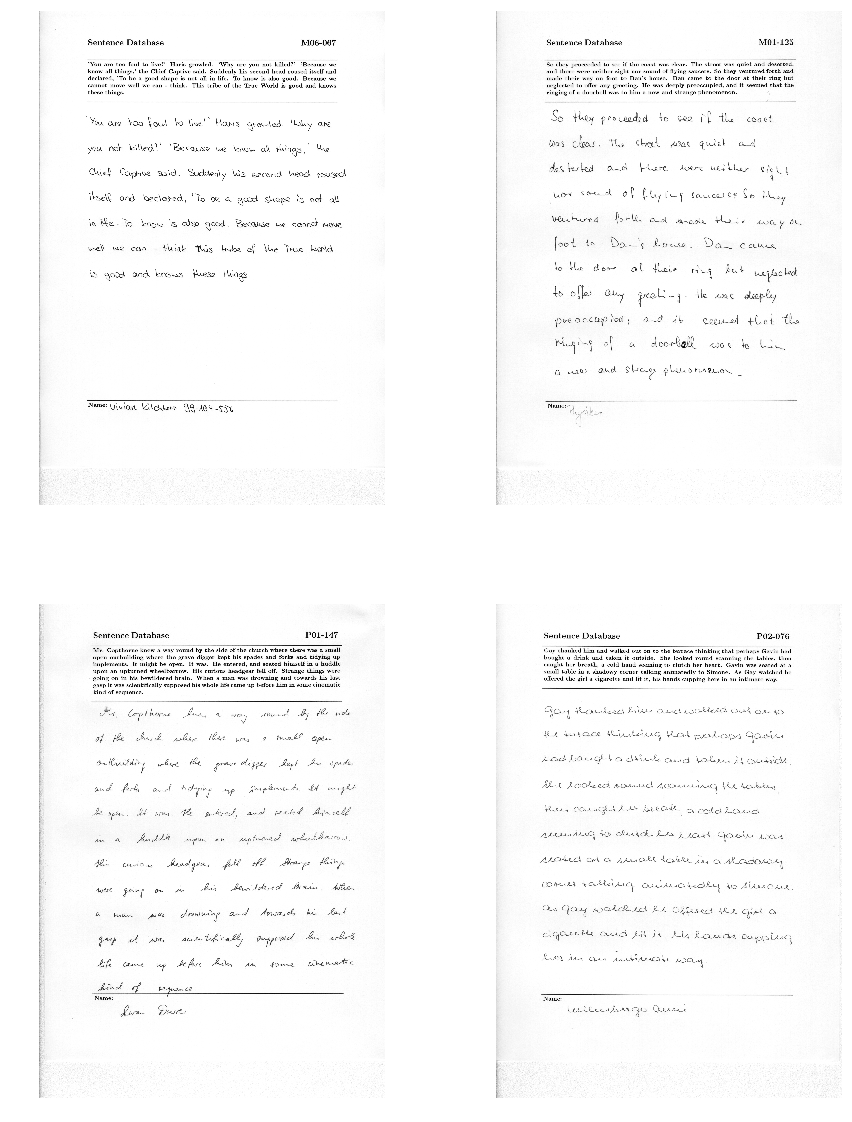

In [61]:
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 10 * len(images)/2))
for i, image in enumerate(images):
    y, x = int(i/2), int(i%2)
    axs[y, x].imshow(image, cmap='Greys_r')
    axs[y, x].axis('off')

### Paragraph segmentation

Given the image of a form in the IAM dataset, predict a bounding box of the handwriten component. The model was trained on using https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.py and an example is presented in https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/master/paragraph_segmentation_dcnn.ipynb

In [14]:
paragraph_segmentation_net = SegmentationNetwork(ctx=ctx)
paragraph_segmentation_net.cnn.load_parameters("models/paragraph_segmentation2.params", ctx=ctx)

In [15]:
paragraph_segmentation_net.hybridize()

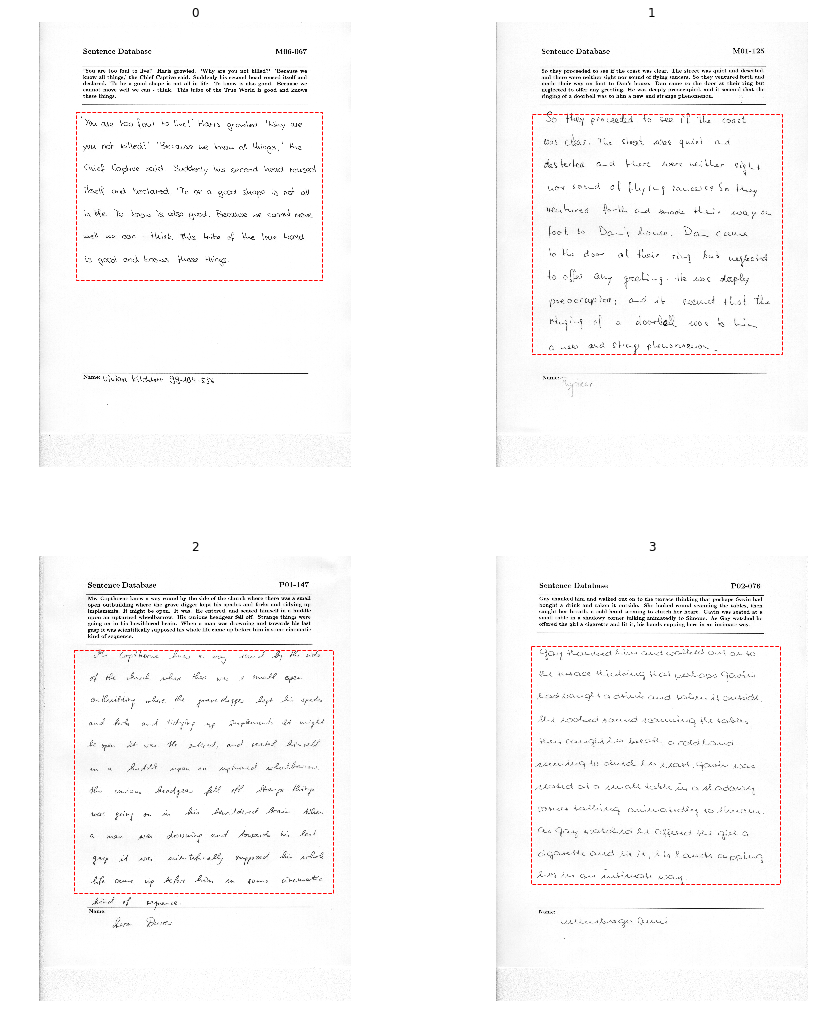

In [62]:
form_size = (1120, 800)

predicted_bbs = []

fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))
for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)
    resized_image = paragraph_segmentation_transform(image, form_size)
    bb_predicted = paragraph_segmentation_net(resized_image.as_in_context(ctx))
    bb_predicted = bb_predicted[0].asnumpy()
    bb_predicted = expand_bounding_box(bb_predicted, expand_bb_scale_x=0.03,
                                           expand_bb_scale_y=0.03)
    predicted_bbs.append(bb_predicted)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].set_title("{}".format(i))

    (x, y, w, h) = bb_predicted
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[s_y, s_x].add_patch(rect)
    axs[s_y, s_x].axis('off')

## Image Processing

Crop the handwriting component out of the original IAM form.



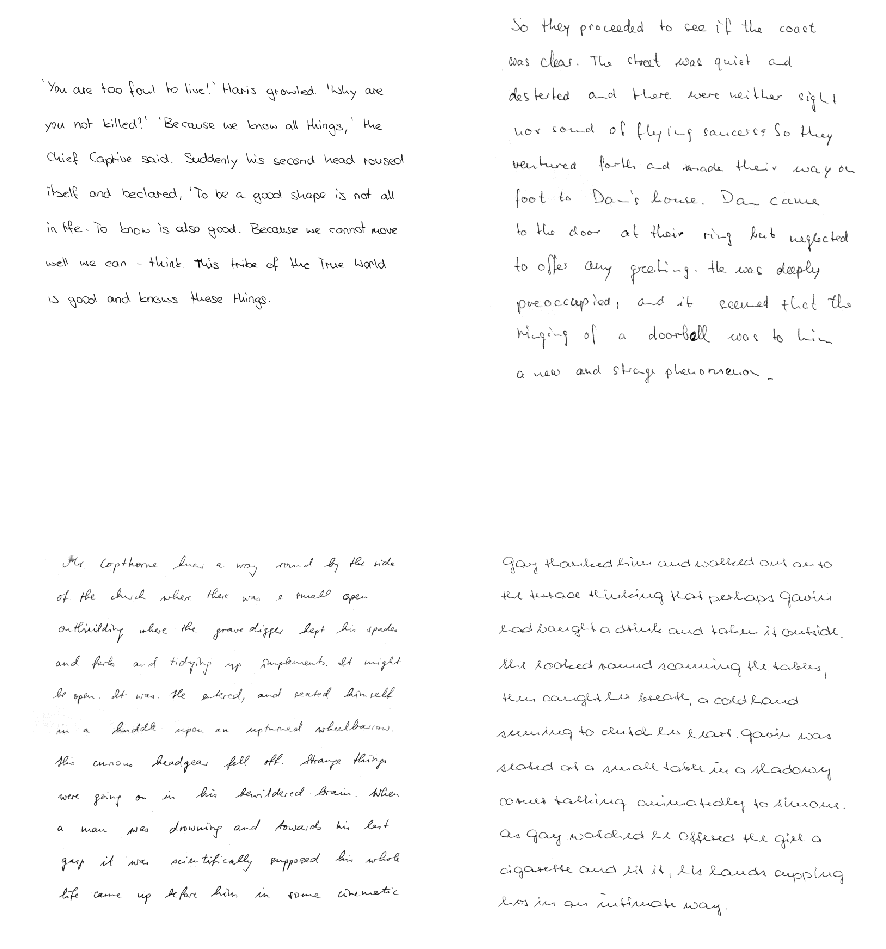

In [63]:
segmented_paragraph_size = (700, 700)
fig, axs = plt.subplots(int(len(images)/2), 2, figsize=(15, 9 * len(images)/2))

paragraph_segmented_images = []

for i, image in enumerate(images):
    s_y, s_x = int(i/2), int(i%2)

    bb = predicted_bbs[i]
    image = crop_handwriting_page(image, bb, image_size=segmented_paragraph_size)
    paragraph_segmented_images.append(image)
    
    axs[s_y, s_x].imshow(image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')

## Line/word segmentation

Given a form with only handwritten text, predict a bounding box for each word. The model was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/word_segmentation.py

In [18]:
word_segmentation_net = WordSegmentationNet(2, ctx=ctx)
word_segmentation_net.load_parameters("models/word_segmentation2.params")
word_segmentation_net.hybridize()

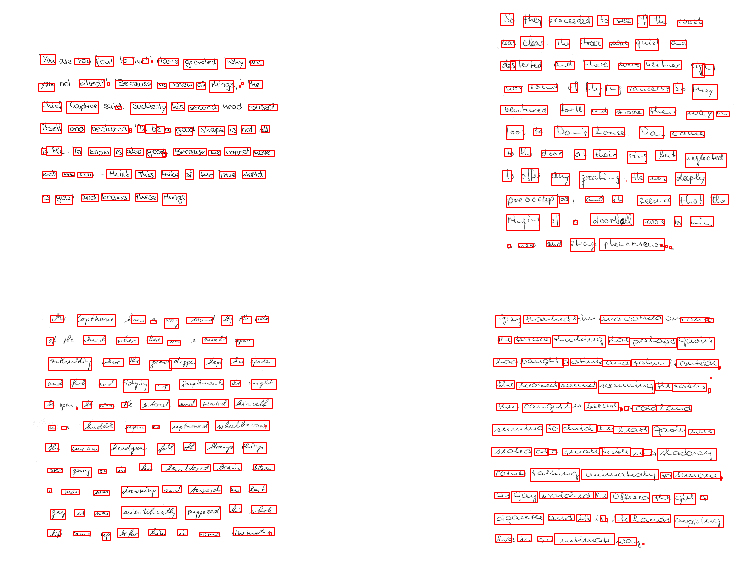

In [64]:
min_c = 0.1
overlap_thres = 0.1
topk = 600

fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 5 * int(len(paragraph_segmented_images)/2)))
predicted_words_bbs_array = []

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)

    predicted_bb = predict_bounding_boxes(
        word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)

    predicted_words_bbs_array.append(predicted_bb)
    
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    for j in range(predicted_bb.shape[0]):     
        (x, y, w, h) = predicted_bb[j]
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)
        axs[s_y, s_x].axis('off')

### Word to line image processing
Algorithm to sort then group all words within a line together.

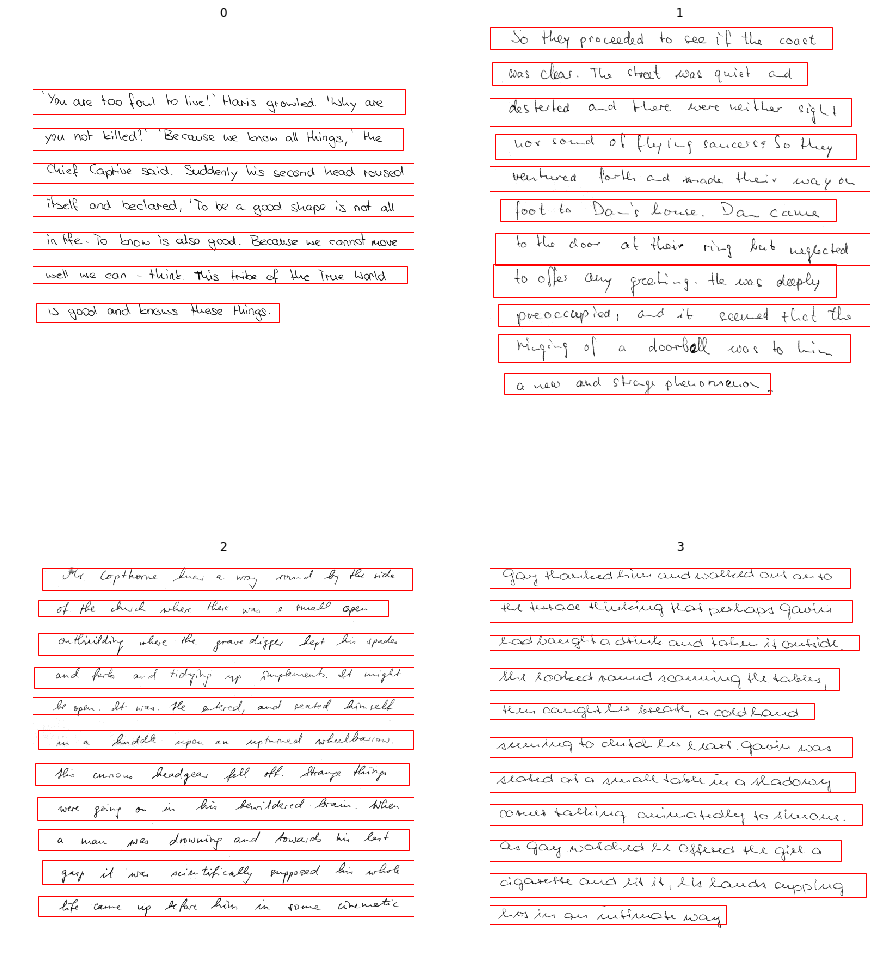

In [65]:
line_images_array = []
fig, axs = plt.subplots(int(len(paragraph_segmented_images)/2), 2, 
                        figsize=(15, 9 * int(len(paragraph_segmented_images)/2)))

for i, paragraph_segmented_image in enumerate(paragraph_segmented_images):
    s_y, s_x = int(i/2), int(i%2)
    axs[s_y, s_x].imshow(paragraph_segmented_image, cmap='Greys_r')
    axs[s_y, s_x].axis('off')
    axs[s_y, s_x].set_title("{}".format(i))
    
    predicted_bbs = predicted_words_bbs_array[i]
    line_bbs = sort_bbs_line_by_line(predicted_bbs, y_overlap=0.4)
    line_images = crop_line_images(paragraph_segmented_image, line_bbs)
    line_images_array.append(line_images)
    
    for line_bb in line_bbs:
        (x, y, w, h) = line_bb
        image_h, image_w = paragraph_segmented_image.shape[-2:]
        (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)

        rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
        axs[s_y, s_x].add_patch(rect)

## Handwriting recognition
Given each line of text, predict a string of the handwritten text. This network was trained with https://github.com/ThomasDelteil/Gluon_OCR_LSTM_CTC/blob/language_model/handwriting_line_recognition.py

In [21]:
handwriting_line_recognition_net = HandwritingRecognitionNet(rnn_hidden_states=512,
                                                             rnn_layers=2, ctx=ctx, max_seq_len=160)
handwriting_line_recognition_net.load_parameters("models/handwriting_line8.params", ctx=ctx)
handwriting_line_recognition_net.hybridize()

In [66]:
line_image_size = (60, 800)
character_probs = []
for line_images in line_images_array:
    form_character_prob = []
    for i, line_image in enumerate(line_images):
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        line_character_prob = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        form_character_prob.append(line_character_prob)
    character_probs.append(form_character_prob)

### Character Probalities to Text

In [42]:
def get_arg_max(prob):
    '''
    The greedy algorithm convert the output of the handwriting recognition network
    into strings.
    '''
    arg_max = prob.topk(axis=2).asnumpy()
    return decoder_handwriting(arg_max)[0]

In [43]:
def get_beam_search(prob, width=20, k=4):
    possibilities = ctcBeamSearch(prob.softmax()[0].asnumpy(), alphabet_encoding, None, width, k)
    return possibilities[0]

## Denoising the text output

We use a seq2seq denoiser to translate noisy input to better output

In [25]:
FEATURE_LEN = 150
denoiser = Denoiser(alphabet_size=len(ALPHABET), max_src_length=FEATURE_LEN, max_tgt_length=FEATURE_LEN, num_heads=16, embed_size=256, num_layers=2)
denoiser.load_parameters('models/denoiser2.params', ctx=ctx)

In [26]:
denoiser.hybridize(static_alloc=True)

We use a language model in order to rank the propositions from the denoiser

In [27]:
ctx_nlp = mx.gpu(3)
language_model, vocab = nlp.model.big_rnn_lm_2048_512(dataset_name='gbw', pretrained=True, ctx=ctx_nlp)
moses_tokenizer = nlp.data.SacreMosesTokenizer()
moses_detokenizer = nlp.data.SacreMosesDetokenizer()

We use beam search to sample the output of the denoiser

In [28]:
beam_sampler = nlp.model.BeamSearchSampler(beam_size=30,
                                           decoder=denoiser.decode_logprob,
                                           eos_id=EOS,
                                           scorer=nlp.model.BeamSearchScorer(),
                                           max_length=150)

In [29]:
def generate_sequences(sampler, inputs, begin_states, sentence, language_model):
    samples, scores, valid_lengths = sampler(inputs, begin_states)
    samples = samples[0].asnumpy()
    scores = scores[0].asnumpy()
    valid_lengths = valid_lengths[0].asnumpy()
    max_score = -10e20
    
    # Heuristic #1
    #If the sentence is correct, let's not try to change it 
    sentence_tokenized = [i.replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&") for i in moses_tokenizer(sentence)]
    sentence_correct = True
    for token in sentence_tokenized:
        if (token not in vocab or vocab[token] > 400000) and token.lower() not in ["don't", "doesn't", "can't", "won't", "ain't", "couldn't", "i'd", "you'd", "he's", "she's", "it's", "i've", "you've", "she'd"]:
            sentence_correct = False
            break
    if sentence_correct:
        return sentence
    
    # Heuristic #2
    # We want sentence that have the most in-vocabulary words
    # and we penalize sentences that have out of vocabulary words 
    # that do not start with a capital letter
    for i, sample in enumerate(samples):
        tokens = decode_char(sample[:valid_lengths[i]])
        tokens = [i.replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&") for i in moses_tokenizer(tokens)]
        score = 0
        
        for t in tokens:
            # Boosting names
            if (t in vocab and vocab[t] < 450000) or (len(t) > 0 and t.istitle()):
                score += 0
            else:
                score -= 1
            score -= 0
        if score == max_score:
            max_score = score
            best_tokens.append(tokens)
        elif score > max_score:
            max_score = score
            best_tokens = [tokens]

    # Heurisitic #3
    # Smallest edit distance
    # We then take the sentence with the lowest edit distance
    # From the predicted original sentence
    best_dist = 1000
    output_tokens = best_tokens[0]
    best_tokens_ = []
    for tokens in best_tokens:
        dist = leven.levenshtein(sentence, ' '.join(moses_detokenizer(tokens)))
        if dist < best_dist:
            best_dist = dist
            best_tokens_ =[tokens]
        elif dist == best_dist:
            best_tokens_.append(tokens)
            
    # Heuristic #4
    # We take the sentence with the smallest number of tokens 
    # to avoid split up composed words
    min_len = 10e20
    for tokens in best_tokens_:
        if len(tokens) < min_len:
            min_len = len(tokens)
            best_tokens__ = [tokens]
        elif len(tokens) == min_len:
            best_tokens__.append(tokens)

    # Heuristic #5 
    # Lowest ppl
    # If we still have ties we take the sentence with the lowest
    # Perplexity score according to the language model
    best_ppl = 10e20            
    for tokens in best_tokens__:
        if len(tokens) > 1:
            inputs = vocab[tokens]
            hidden = language_model.begin_state(batch_size=1, func=mx.nd.zeros, ctx=ctx_nlp)
            output, _ = language_model(mx.nd.array(inputs).expand_dims(axis=1).as_in_context(ctx_nlp), hidden)
            output = output.softmax()
            l = 0
            for i in range(1, len(inputs)):
                l += -output[i-1][0][inputs[i]].log()
            ppl = (l/len(inputs)).exp()
            if ppl < best_ppl:
                output_tokens = tokens
                best_ppl = ppl
    output = ' '.join(moses_detokenizer(output_tokens))
    
    
    # Heuristic #6
    # Sometimes there are artefact at the end of the corrected sentence
    # We cut the end of the sentence
    if len(output) > len(sentence) + 10:
        output = output[:len(sentence)+2]
    return output

In [30]:
def get_denoised(prob, ctc_bs=False):
    if ctc_bs: # Using ctc beam search before denoising yields only limited improvements a is very slow
        text = get_beam_search(prob)
    else:
        text = get_arg_max(prob)
    src_seq, src_valid_length = encode_char(text)
    src_seq = mx.nd.array([src_seq], ctx=ctx)
    src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
    encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
    states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                      encoder_valid_length=src_valid_length)
    inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
    output = generate_sequences(beam_sampler, inputs, states, text, language_model)
    return output.strip()

In [31]:
sentence = "This sentnce has an eror"
src_seq, src_valid_length = encode_char(sentence)
src_seq = mx.nd.array([src_seq], ctx=ctx)
src_valid_length = mx.nd.array(src_valid_length, ctx=ctx)
encoder_outputs, _ = denoiser.encode(src_seq, valid_length=src_valid_length)
states = denoiser.decoder.init_state_from_encoder(encoder_outputs, 
                                                  encoder_valid_length=src_valid_length)
inputs = mx.nd.full(shape=(1,), ctx=src_seq.context, dtype=np.float32, val=BOS)
print(sentence)
print("Choice")
print(generate_sequences(beam_sampler, inputs, states, sentence, language_model))

This sentnce has an eror
Choice
This sentence has an error


## Qualitative Result

- [AM] Arg Max CTC Decoding
- [BS] Beam Search CTC Decoding
- [D ] Adding Text Denoiser

[AM] '"You are too foul to live." Maris growled. "Why are
[D ] '"You are too foul to live." Maris growled. "Why are
[AM] you not killed?" 'Because we know all things,' the
[D ] you not killed?" 'Because we know all things,' the
[AM] chief Captive said. Suddenly his second head noused
[D ] chief Captive said. Suddenly his second head roused
[AM] itself and beclared, 'to be a good shape is not all
[D ] itself and declared, 'to be a good shape is not all
[AM] in rhe. To know is also good. Because we cannot move
[D ] in rhe. To know is also good. Because we cannot move
[AM] well we can -thirk. This tribe of the True world
[D ] well we can think. This tribe of the True world
[AM] is good and knoms these things.
[D ] is good and knows these things.
[AM] So they proceeded to see if the coact
[D ] So they proceeded to see if the coach
[AM] was clear. The street was qniet and
[D ] was clear. The street was quiet and.
[AM] desterted and there were meither sight
[D ] deserted and there were neith

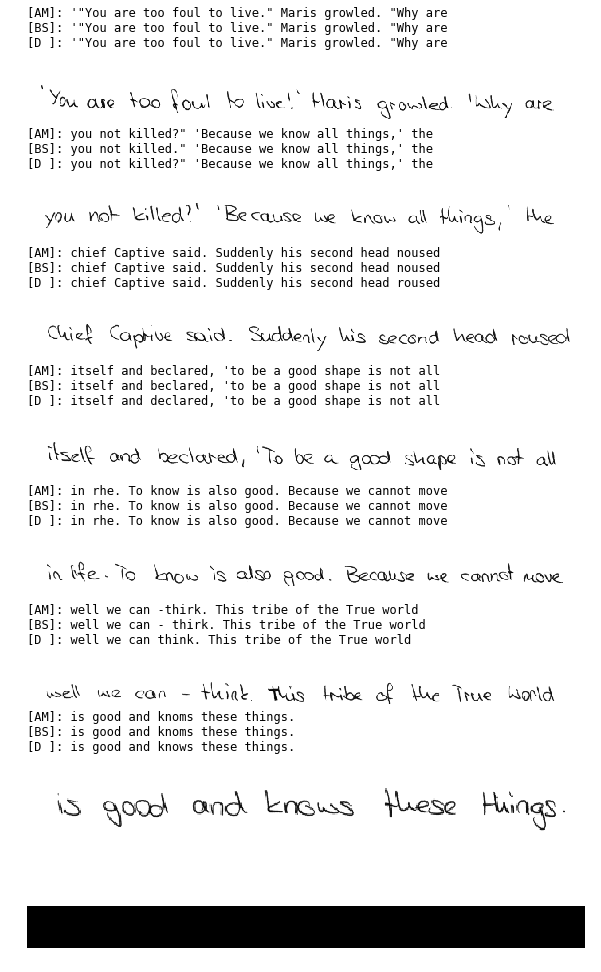

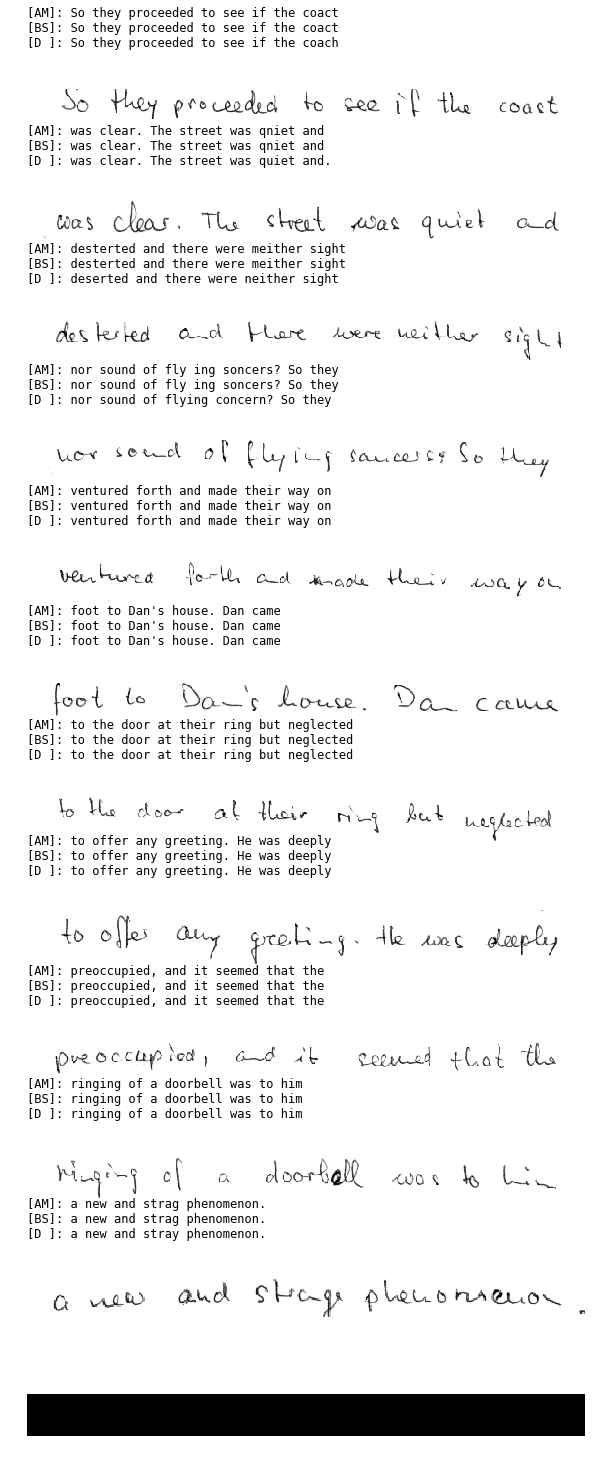

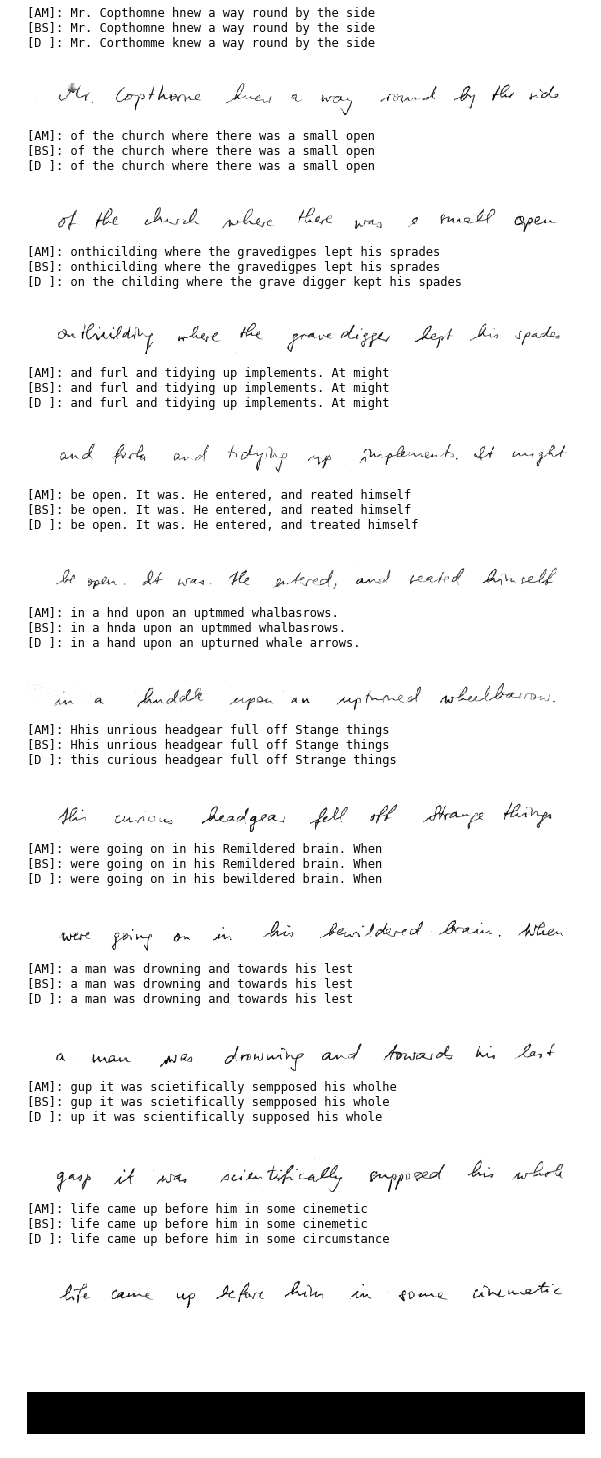

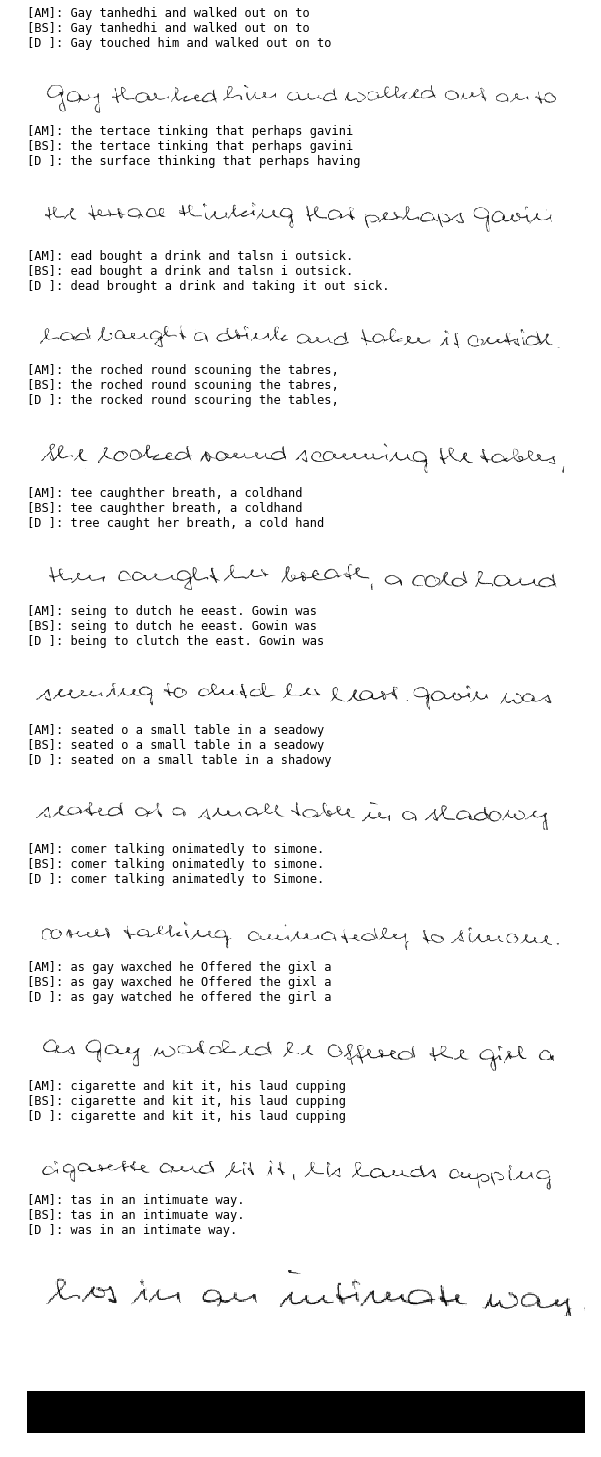

In [67]:
for i, form_character_probs in enumerate(character_probs):
    fig, axs = plt.subplots(len(form_character_probs) + 1, 
                            figsize=(10, int(1 + 2.3 * len(form_character_probs))))
    for j, line_character_probs in enumerate(form_character_probs):
        decoded_line_am = get_arg_max(line_character_probs)
        print("[AM]",decoded_line_am)
        decoded_line_bs = get_beam_search(line_character_probs)
        decoded_line_denoiser = get_denoised(line_character_probs, ctc_bs=False)
        print("[D ]",decoded_line_denoiser)
        
        line_image = line_images_array[i][j]
        axs[j].imshow(line_image.squeeze(), cmap='Greys_r')            
        axs[j].set_title("[AM]: {}\n[BS]: {}\n[D ]: {}\n\n".format(decoded_line_am, decoded_line_bs, decoded_line_denoiser), fontdict={"horizontalalignment":"left", "family":"monospace"}, x=0)
        axs[j].axis('off')
    axs[-1].imshow(np.zeros(shape=line_image_size), cmap='Greys_r')
    axs[-1].axis('off')

# Quantitative Results
Iterative through the test data with the previous tests to obtain the total Character Error Rate (CER).

In [68]:
sclite = Sclite_helper()

def get_qualitative_results_lines(denoise_func):
    sclite.clear()
    test_ds_line = IAMDataset("line", train=False)
    for i in tqdm(range(1, len(test_ds_line))):
        image, text = test_ds_line[i]
        line_image = exposure.adjust_gamma(image, 1)
        line_image = handwriting_recognition_transform(line_image, line_image_size)
        character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
        decoded_text = denoise_func(character_probabilities)
        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        sclite.add_text([decoded_text], [actual_text])
    
    _, er = sclite.get_cer()
    print("Mean CER = {}".format(er))
    return er

In [69]:
def get_qualitative_results(denoise_func):
    sclite.clear()
    for i in tqdm(range(1, len(test_ds))):
        image, text = test_ds[i]
        resized_image = paragraph_segmentation_transform(image, image_size=form_size)
        paragraph_bb = paragraph_segmentation_net(resized_image.as_in_context(ctx))
        paragraph_bb = paragraph_bb[0].asnumpy()
        paragraph_bb = expand_bounding_box(paragraph_bb, expand_bb_scale_x=0.01,
                                               expand_bb_scale_y=0.01)
        paragraph_segmented_image = crop_handwriting_page(image, paragraph_bb, image_size=segmented_paragraph_size)
        word_bb = predict_bounding_boxes(word_segmentation_net, paragraph_segmented_image, min_c, overlap_thres, topk, ctx)        
        line_bbs = sort_bbs_line_by_line(word_bb, y_overlap=0.4)
        line_images = crop_line_images(paragraph_segmented_image, line_bbs)

        predicted_text = []
        for line_image in line_images:
            line_image = exposure.adjust_gamma(line_image, 1)
            line_image = handwriting_recognition_transform(line_image, line_image_size)
            character_probabilities = handwriting_line_recognition_net(line_image.as_in_context(ctx))
            decoded_text = denoise_func(character_probabilities)
            predicted_text.append(decoded_text)

        actual_text = text[0].replace("&quot;", '"').replace("&apos;","'").replace("&amp;", "&")
        actual_text = actual_text.split("\n")
        if len(predicted_text) > len(actual_text):
            predicted_text = predicted_text[:len(actual_text)]
        sclite.add_text(predicted_text, actual_text)
    
    _, er = sclite.get_cer()
    print("Mean CER = {}".format(er))
    return er

CER with pre-segmented lines

In [70]:
get_qualitative_results_lines(get_arg_max)

100%|██████████| 1859/1859 [01:05<00:00, 28.26it/s]


Mean CER = 7.200000000000003


7.200000000000003

In [71]:
get_qualitative_results_lines(get_denoised)

100%|██████████| 1859/1859 [13:58<00:00,  2.22it/s]


Mean CER = 5.799999999999997


5.799999999999997

CER full pipeline

In [72]:
get_qualitative_results(get_arg_max)

100%|██████████| 231/231 [01:13<00:00,  3.15it/s]


Mean CER = 9.900000000000006


9.900000000000006

In [73]:
get_qualitative_results(get_beam_search)

100%|██████████| 231/231 [13:47<00:00,  3.58s/it]


Mean CER = 9.900000000000006


9.900000000000006

In [74]:
cer_denoiser = get_qualitative_results(get_denoised)
cer_denoiser

100%|██████████| 231/231 [13:20<00:00,  3.47s/it]


Mean CER = 8.5


8.5

#### ideas:
    - weighted levenshtein
    - re-trained the language model on GBW [~ didn't work too well]
    - only penalize non-existing words
    - Add single word training for denoiser
    - having 2 best edit distance rather than single one
    - split sentences based on punctuation
    - use CTC loss for ranking
    - meta model to learn to weight the scores from each thing